# Predict next time series value with LSTM + Lineal

* https://www.crosstab.io/articles/time-series-pytorch-lstm
* https://www.kaggle.com/datasets/prasoonkottarathil/ethereum-historical-dataset
* https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import random

import torch
from torch.nn import MSELoss
from torch.utils.data import DataLoader

import pytorch_common.util    as pu
from   pytorch_common.util import set_device_name, \
                                  get_device, \
                                  LoggerBuilder

from pytorch_common.callbacks.output import Logger, \
                                            MetricsPlotter
from pytorch_common.callbacks import EarlyStop, \
                                     ReduceLROnPlateau, \
                                     Validation, \
                                     SaveBestModel

from pytorch_common.callbacks.output import OutputHook


from data   import SequenceDataset, \
                   standarizer, \
                   variable_to_sequences, \
                   features_target_split, \
                   train_test_split
from util   import set_seed, \
                   loss_wrapper

from module import TimeSeriesPredictor

## Functions

In [4]:
def interpolation_plot(times=500):
    feature, _  = test_dataset[0]
    complete_pred_values = feature.squeeze(1).tolist()

    pred_values, true_values = [], []

    for time in  range(1, times+1):
        features = complete_pred_values[-sequence_size:]
        input = torch.tensor(features).unsqueeze(1).unsqueeze(0)

        next_value  = model.predict(input)

        complete_pred_values.append(next_value.item())
        pred_values.append(next_value.item())

        _, y_true = test_dataset[time]
        true_values.append(y_true.item())

    plot(pred_values, true_values)

def plot(y_pred, y_true, times=100):
    sns.set_style("darkgrid")
    plt.plot(y_true[:times], color='green',label="True")        
    plt.plot(y_pred[:times], color='blue', label="Prediction")
    plt.legend()
    plt.show()

def plot_eval():
    y_pred, y_true = model.validation(test_loader)
    plot(y_pred, y_true)

## Setup

In [5]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [6]:
pu.set_device_name('gpu')

In [7]:
pu.get_device()

device(type='cuda', index=0)

In [8]:
torch.cuda.is_available()

True

In [9]:
torch.__version__

'1.11.0'

In [11]:
set_seed(42)

In [12]:
WEIGHTS_PATH   = '../weights'
WINDOW_SIZE    = 200
N_WORKERS      = 24
BATCH_SIZE     = 300
TRAIN          = True
n_hidden_units = 5
sequence_size  = WINDOW_SIZE -1
n_epochs       = 100
n_layers       = 5
dropout        = 0
test_percent   = 0.1

CFG = {
    'etherium': { 'path': '../datasets/ETH_1H.csv',                 'variable': 'close' },
    'min-temp': { 'path': '../datasets/daily-min-temperatures.csv', 'variable': 'temp'  },
    'dataset' : 'min-temp'
}

DATASET_PATH = CFG[CFG['dataset']]['path']
VARIABLE     = CFG[CFG["dataset"]]["variable"]

## Preprocessing

#### 1. Load dataset.

In [13]:
df = pd.read_csv(DATASET_PATH)
df.columns = df.columns.str.lower()
df = df[['date', VARIABLE]]

dataset = df.sort_values(by='date',ascending=True)
dataset.head()

,date,temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [14]:
dataset.shape

(3650, 2)

#### 2. Train-test splot and normalize data:

In [15]:
dataset = dataset.sort_values(by='date',ascending=True)

train_set,      test_set      = train_test_split(dataset, test_percent)

norm_train_set, norm_test_set = standarizer(train_set, test_set, columns=[VARIABLE])

train_set.shape, test_set.shape, norm_train_set.shape, norm_test_set.shape

((3285, 2), (365, 2), (3285, 3), (365, 3))

In [16]:
norm_train_set.tail()

,date,temp,norm_temp
3280,1989-12-27,13.3,0.532061
3281,1989-12-28,11.7,0.141000
3282,1989-12-29,10.4,-0.176736
3283,1989-12-30,14.4,0.800914
3284,1989-12-31,12.7,0.385413


In [17]:
norm_test_set.head()

,date,temp,norm_temp
3285,1990-01-01,14.8,0.898679
3286,1990-01-02,13.3,0.532061
3287,1990-01-03,15.6,1.094209
3288,1990-01-04,14.5,0.825356
3289,1990-01-05,14.3,0.776473


#### 3. Separare into sequences using a sliding window.

In [18]:
variable_norm_values = norm_train_set[f'norm_{VARIABLE}']

train_set_sequences = variable_to_sequences(variable_norm_values, WINDOW_SIZE)
test_set_sequences  = variable_to_sequences(variable_norm_values,  WINDOW_SIZE)

train_set_sequences.shape, test_set_sequences.shape

((3086, 200), (3086, 200))

#### 4. Separate sequences into (features=sequence-1, target=last):

In [19]:
train_features, train_targets = features_target_split(train_set_sequences)
test_features,  test_targets  = features_target_split(test_set_sequences)

train_features.shape, train_targets.shape, test_features.shape, test_targets.shape

((3086, 199), (3086,), (3086, 199), (3086,))

In [20]:
torch.tensor(train_features).unsqueeze(2).float().shape

torch.Size([3086, 199, 1])

#### 5. Create a dataset for both train an test sets:

In [21]:
train_dataset = SequenceDataset(train_features, train_targets)
test_dataset  = SequenceDataset(test_features, test_targets)

len(train_dataset), len(test_dataset)

(3086, 3086)

In [22]:
f, t = train_dataset[0]
f.shape, t.shape

(torch.Size([199, 1]), torch.Size([]))

In [23]:
f, t = test_dataset[0]
f.shape, t.shape

(torch.Size([199, 1]), torch.Size([]))

#### 6. Create dataloader for both tra and test datasets:

In [24]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=N_WORKERS)

# f, t = next(iter(train_loader))
# f.shape, t.shape

In [25]:
# f, t = next(iter(test_loader))
# f.shape, t.shape

# Model Definition

In [26]:
model = TimeSeriesPredictor(
    input_size     = 1, 
    n_hidden_units = n_hidden_units, 
    n_layers       = n_layers,
    dropout        = dropout
).to(pu.get_device())

model

TimeSeriesPredictor(
  (rnn): LSTM(1, 5, num_layers=5, batch_first=True)
  (linear): Linear(in_features=5, out_features=1, bias=True)
)

In [36]:
# f, t = next(iter(test_loader))
# f.shape, model(f).shape

(torch.Size([300, 199, 1]), torch.Size([300]))

# Train

<Figure size 576x288 with 1 Axes>

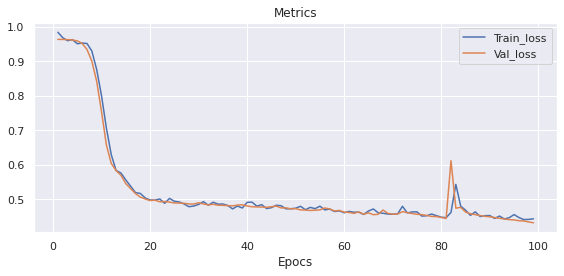

<Figure size 576x288 with 1 Axes>

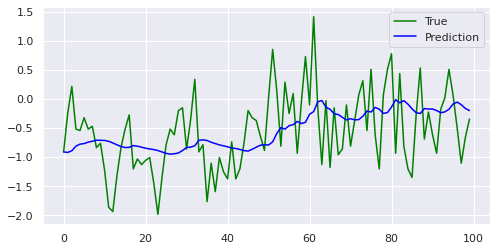

<Figure size 576x288 with 1 Axes>

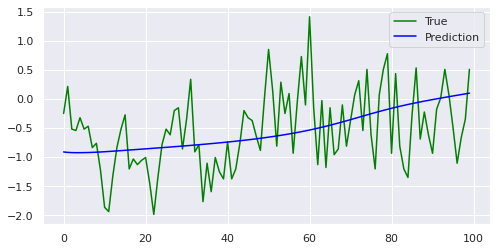

In [37]:
if TRAIN:
    sns.set(rc = {'figure.figsize':(8,4)})

    learning_rate  = 0.001

    loss_fn = MSELoss()

    model.fit(
        train_loader,
        loss_fn   = loss_fn,
        epochs    = n_epochs,
        optimizer = torch.optim.Adam(
            model.parameters(), 
            lr = learning_rate
        ),
        callbacks   = [
            Validation(
                test_loader,
                metrics       = { 'val_loss': loss_wrapper(loss_fn) },
                each_n_epochs = 1
            ),
            Logger(['time', 'epoch', 'train_loss', 'val_loss']),
            MetricsPlotter(metrics=['train_loss', 'val_loss'], plot_each_n_epochs=5),
            OutputHook(lambda ctx: plot_eval(), plot_each_n_epochs=5),
            OutputHook(lambda ctx: interpolation_plot(), plot_each_n_epochs=5),
            #, SaveBestModel(metric='val_loss', path=WEIGHTS_PATH, experiment_name='lstm-time-series')
        ]
    )